# Phenotype classifcation using CellX 

This notebook shows how to take segmented time lapse microscopy images and use h2b fluorescence markers to classfiy mitotic state of the cell cycle. 

The sections of this notebook are as follows:

1. Load images
2. Localise the objects
3. Classify the objects
4. Filter the objects
5. Run btrack, uniting the objects locations over time

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

This notebook uses the dask octopuslite image loader from the CellX/Lowe lab project.

In [27]:
from octopuslite import DaskOctopusLiteLoader, image_generator
import btrack
from tqdm import tqdm
import numpy as np
from scipy.special import softmax
import os
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
%matplotlib inline
plt.rcParams['figure.figsize'] = [18,8]

## 1. Load segmentation images

In [37]:
# load images
expt = 'ND0011'
pos = 'Pos6'
root_dir = '/home/nathan/data'
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
images = DaskOctopusLiteLoader(image_path, crop=(1200,1600), remove_background=False)
## efficiently load segmentation images by providing the path to the generator function
segmentation = image_generator(images.files('mask'), crop=(1200,1600))

Using cropping: (1200, 1600)


## 2. Localise the objects
We need to also measure the mean intensity regionprops parameter in order to differentiate object class.

In [ ]:
objects = btrack.utils.segmentation_to_objects(
    segmentation,
    properties = ('area', 'mean_intensity'),
)

#### Can also assign measured values from raw image to each segment using `skimage.measure.regionprops` parameters
But also need to load the raw images to be measured first and redefine the segmentation image generator as we are using again. Cannot currently save out `intensity_image` parameter to object file.

In [31]:
irfp = image_generator(images.files('irfp'), crop=(1200,1600))
segmentation = image_generator(images.files('mask'), crop=(1200,1600))
detailed_objects = btrack.utils.segmentation_to_objects(
    segmentation,
    irfp,
    properties = ('area', 'mean_intensity', 'intensity_image'), 
)

Using cropping: (1200, 1600)


[INFO][2022/01/21 04:44:05 PM] Localizing objects from segmentation...
[INFO][2022/01/21 04:44:05 PM] Found intensity_image data
[INFO][2022/01/21 04:44:05 PM] Calculating weighted centroids using intensity_image
[INFO][2022/01/21 04:44:05 PM] Objects are of type: <class 'dict'>
[INFO][2022/01/21 04:44:05 PM] ...Found 596 objects in 9 frames.


In [35]:
detailed_objects[0]

,ID,x,y,z,t,dummy,states,label,prob,area,intensity_image
0,0,284.482239,783.94415,0.0,0,False,0,5,0.0,1026,"(37, 36) array"


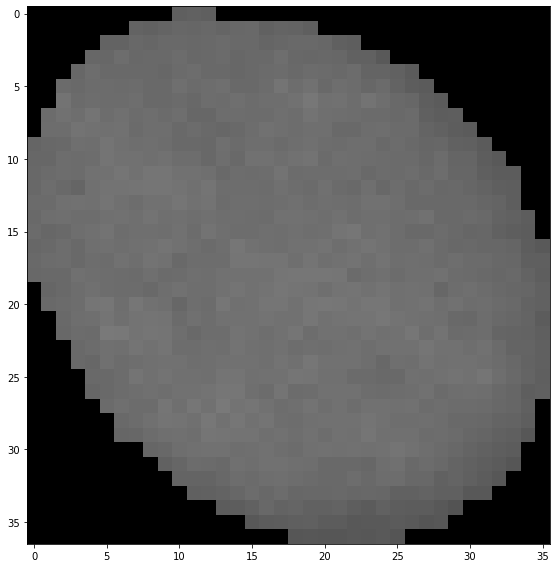

In [33]:
imshow(detailed_objects[0].properties['intensity_image'])

## 2b. Differentiate the objects based on class ID

In [ ]:
objects_irfp = [obj for obg in objects if obj.properties['mean_intensity'] == 1]
objects_rfp = [obj for obg in objects if obj.properties['mean_intensity'] == 2]

## 3. Classify the objects 

In [6]:
from cellx import load_model
from cellx.tools.image import InfinitePaddedImage
from skimage.transform import resize

model = load_model('./models/cellx_classifier_stardist.h5')

In [7]:
LABELS = ["interphase", "prometaphase", "metaphase", "anaphase", "apoptosis"]

In [8]:
def normalize_channels(x):

    for dim in range(x.shape[-1]):
        x[..., dim] = normalize(x[..., dim])
        
    return x

def normalize(x):

    xf = x.astype(np.float32)
    mx = np.mean(xf)
    sd = np.max([np.std(xf), 1./np.prod(x.shape)])

    return (xf - mx) / sd

In [9]:
def classify_objects(image, objects, obj_type=1):
    labels = []
    for n in tqdm(range(image.shape[0])):

        _objects = [o for o in objects if o.t == n]

        crops = []
        to_update = []
        
        
        fp = gfp if obj_type == 1 else rfp


        frame = np.stack(
            [image[n, ...].compute(), fp[n, ...].compute()], 
            axis=-1,
        ) 

        vol = InfinitePaddedImage(frame, mode = 'reflect')

        for obj in _objects:
            xs = slice(int(obj.x-40), int(obj.x+40), 1)
            ys = slice(int(obj.y-40), int(obj.y+40), 1)

            crop = vol[ys, xs, :]
            crop = resize(crop, (64, 64), preserve_range=True).astype(np.float32)

            if crop.shape == (64 ,64, 2):
                crops.append(normalize_channels(crop))
                to_update.append(obj)
            else:
                print(crop.shape)

        if not crops:
            continue


        pred = model.predict(np.stack(crops, axis=0))

        assert pred.shape[0] == len(_objects)
        for idx in range(pred.shape[0]):
            obj = _objects[idx]

            pred_label = np.argmax(pred[idx, ...])
            pred_softmax = softmax(pred[idx, ...])

            logits = {f"prob_{k}": pred_softmax[ki] for ki, k in enumerate(LABELS)}

            obj.label = pred_label
            obj.properties = logits
            
    return objects

#### Load raw brightfield images for classifier

In [ ]:
bf = images['brightfield']

#### Classify objects

In [ ]:
objects_irfp = classify_objects(bf, objects_irfp, obj_type = 1)
objects_rfp = classify_objects(bf, objects_rfp, obj_type = 2)

#### Inspect an example object

In [ ]:
objects_gfp[0]

#### Save out classified iRFP objects

In [ ]:
with btrack.dataio.HDF5FileHandler(
    f'{root_dir}/{expt}/{pos}/segmented.h5', 'w', obj_type='obj_type_1',
) as hdf:
    #hdf.write_segmentation(masks['mask'])
    hdf.write_objects(objects_irfp)

#### Save out classified RFP objects

In [ ]:
with btrack.dataio.HDF5FileHandler(
    f'{root_dir}/{expt}/{pos}/segmented.h5', 'w', obj_type='obj_type_2',
) as hdf:
    #hdf.write_segmentation(masks['mask'])
    hdf.write_objects(objects_rfp)

## 4. Filter the objects 

Based on segments that are too small to feasibly be cells

In [ ]:
objects_irfp = [o for o in objects_gfp if o.properties['area']>100.]
objects_rfp = [o for o in objects_rfp if o.properties['area']>100.]

## 5. Run btrack  

Unite each object with it's subsequent position at the following time point and export as a tracking file

#### For GFP objects

In [ ]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        './models/MDCK_config_wildtype.json'
    )
    tracker.max_search_radius = 40

    # append the objects to be tracked
    tracker.append(objects)

    # set the volume
    tracker.volume=((0, 1200), (0, 1600), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(f'{root_dir}/{expt}/{pos}/tracks.h5', obj_type='obj_type_1')

    # get the tracks in a format for napari visualization (optional)
    visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    irfp_tracks = tracker.tracks

#### For RFP objects

In [ ]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        './models/MDCK_config_wildtype.json'
    )
    tracker.max_search_radius = 40

    # append the objects to be tracked
    tracker.append(objects)

    # set the volume
    tracker.volume=((0, 1200), (0, 1600), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(f'{root_dir}/{expt}/{pos}/tracks.h5', obj_type='obj_type_2')

    # get the tracks in a format for napari visualization (optional)
    visaulise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    rfp_tracks = tracker.tracks